# TP 2 - Organizacion de Datos

## Oh La La... Data!

* **Hamma AALI CHTOUKI** --- *Padrón 106607 - Alumno regular de intercambio.*  
* **Aymeryc COUSAERT** ------  *Padrón 105464 - Alumno regular de intercambio.*
* **Mariana VINYOLAS**  ---------  *Alumna oyente.*

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import re
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importamos el dataset

Hacemos ademas un procesamiento del texto para eliminar stopwords y caracteres

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')

In [4]:
df['text'] = df['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
    string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

df['text_clean'] = df['text'].apply(lambda x: clean_str(str(x)))

In [5]:
# eliminamos stopwords
stop = stopwords.words('english')

df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
df['text_clean'] = df['text_clean'].str.replace('[^\w\s]','')

In [6]:
pd.set_option('display.max_colwidth', 100)

In [7]:
df[['text', 'text_clean']].sample(5)

,text,text_clean
1248,fire displaces families and damages two buildings in troy: fire broke out on fourth street inû_...,fire displaces families damages two buildings troy fire broke fourth street inû_ news
6494,@unrealtouch fuck sake john jesus my heart just sunk.,fuck sake john jesus heart sunk
5883,watch this airport get swallowed up by a sandstorm in under a minute http://t.co/gaotrg4mtr,watch airport get swallowed sandstorm minute
4256,something frightening is happening to the weather in the middle east http://t.co/bdotq8dsln,something frightening happening weather middle east
3647,'among other main factors behind pedestrian fatalities are people failing to yield to a car' htt...,among main factors behind pedestrian fatalities people failing yield car


In [8]:
X = df['text_clean'].values 
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)      

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5329,), (2284,), (5329,), (2284,))

In [9]:
vocab_size = 80000
# vocab_size = len(word_index)+1
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" 

In [10]:

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

In [11]:
# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

## Entrenamos una red neuronal con Embedding


In [12]:
# instanciamos el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Conv1D( filters=5 ,kernel_size=5, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) ,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          10240000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,253,001
Trainable params: 10,253,001
Non-trainable params: 0
____________________________________________

In [13]:
num_epochs = 4
batch_size = 30
history = model.fit(X_train, y_train, epochs=num_epochs,
                    batch_size=batch_size,validation_data=(X_test, y_test))

Epoch 1/4
178/178 [==============================] - 40s 224ms/step - loss: 0.6826 - accuracy: 0.5701 - val_loss: 0.6785 - val_accuracy: 0.5709
Epoch 2/4
178/178 [==============================] - 39s 220ms/step - loss: 0.6653 - accuracy: 0.5701 - val_loss: 0.6370 - val_accuracy: 0.5709
Epoch 3/4
178/178 [==============================] - 41s 231ms/step - loss: 0.5308 - accuracy: 0.6836 - val_loss: 0.4883 - val_accuracy: 0.7526
Epoch 4/4
178/178 [==============================] - 41s 228ms/step - loss: 0.3733 - accuracy: 0.8313 - val_loss: 0.4864 - val_accuracy: 0.7890


## Visualizacion del training


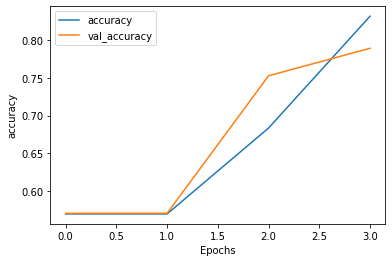

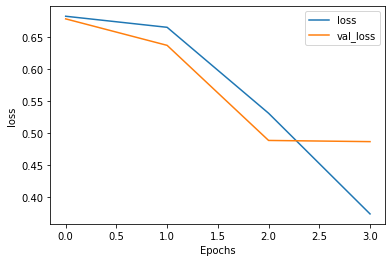

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9000
Testing Accuracy:  0.7890


## Predicciones en el test set

Procesamos el dataset **test** para predecir sus labels

In [16]:
test = pd.read_csv('test.csv')

test['text'] = test['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
    string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

test['text_clean'] = test['text'].apply(lambda x: clean_str(str(x)))



stop = stopwords.words('english')

test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
test['text_clean'] = test['text_clean'].str.replace('[^\w\s]','')

In [17]:
test[['text', 'text_clean']].sample(5)

,text,text_clean
1499,i liked a @youtube video from @shawlarmedeai http://t.co/nn4fy1wbxf easy natural bride makeup tu...,liked video easy natural bride makeup tutorial makeup explosion ft abh shadow
556,my happy pensioner stories\nsafe buildings: watching a report on unsafe cladding catching fire i...,happy pensioner stories safe buildings watching report unsafe cladding catching fire melbourne same
3155,wild fires! http://t.co/egrmdkxpoi,wild fires
1073,#amtrak rail #disaster http://t.co/h6ol73kzjg http://t.co/qfydu4pvgk,rail
691,emergency services called to bacup after 'strong' chemical smells http://t.co/hjj7eftj7o,emergency services called bacup strong chemical smells


In [18]:
test_tweets = test['text_clean'].values

# Creamos las sequencias
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           
    
classes = model.predict_classes(test_padded)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
classes

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [20]:
type(classes)

numpy.ndarray

In [21]:
# df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
# ...                    columns=['a', 'b', 'c'])

In [22]:
classes = pd.DataFrame(classes, columns=[ 'target'] )

In [23]:
classes.head()

,target
0,1
1,0
2,1
3,0
4,1


In [24]:
test.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, stay safe everyone.",heard different cities stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all",forest fire spot pond geese fleeing across street cannot save
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,apocalypse lighting wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills china taiwan


In [25]:
test['target'] = classes['target']

In [26]:
results = test[['id', 'target']]

In [ ]:
results.drop()

In [27]:
results.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [29]:

results.to_csv('results.csv', index=False)